In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_preprocessing as dp
import time
import seaborn as sns
import feature_selection as fs
from mpl_toolkits.mplot3d import Axes3D
from pylab import plot, axis, show, pcolor, colorbar, bone
from minisom import MiniSom
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_breast_cancer
from matplotlib import style
style.use('ggplot')


In [2]:
def remove_outliers_cluster(x, cluster_features):
    # Limpia los outliers de las variables especificadas en cluster_features
    # en el DataFrame x.
    
    # Parámetros:
    #        x (DataFrame): DataFrame sobre el que limpiar los outliers.
    #        cluster_features (list): Lista que contiene las strings de las variables a limpiar.
    
    # Devuelve:
    #        x (Dataframe): DataFrame sin outliers.
    
    for col in cluster_features:
        y = x[col]
        q1 = y.quantile(.25)
        q3 = y.quantile(.75)
        IQR = (q3 - q1) * 1.5
        x = x[(y < q3 + IQR)]
        x = x[(y > q1 - IQR)]
    return x

In [85]:
literatura = ['NOCHES', 'ALOJ_CATEG', 'PERSONAS_TOTAL', 'ISLA', 'PAQUETE_TURISTICO', 'INGRESOS', 'PRIMERA_VISITA_CANARIAS',
              'NACIONALIDAD', 'EDAD', 'ACTIV_PLAYA', 'ACTIV_PISCINA', 'ACTIV_PASEAR', 'ACTIV_ISLA', 'SEXO',
              'ACTIV_EXCURS_ORGANIZ', 'ACTIV_EXCURS_MAR', 'ACTIV_ASTRONOMIA', 'ACTIV_POPULAR', 'ACTIV_GASTRONOMIA_CANARIA',
              'ACTIV_PARQUES_OCIO', 'ACTIV_OCIO', 'ACTIV_BELLEZA', 'ACTIV_DEPORTIVA', 'ACTIV_NATURALEZA', 'ACTIV_MAR']

literatura_corr1 = ['NOCHES', 'PERSONAS_TOTAL', 'INGRESOS', 'EDAD', 'ACTIV_PISCINA',
                    'ACTIV_PARQUES_OCIO', 'ALOJ_CATEG_HOTEL4', 'ALOJ_CATEG_HOTEL5',
                    'ALOJ_CATEG_PROPIA', 'PAQUETE_TURISTICO_ALGUNO_GRATIS',
                    'PAQUETE_TURISTICO_SI', 'NACIONALIDAD_ESP724']

In [87]:
X = dp.load_dataset('./datos/GASTO_TURISTICO_2018_ORIGINAL_2.csv', ';', ',', predictors=literatura, dummies=False,
                    desglose=False)

features = X.copy()
features = pd.get_dummies(features)

print(features.shape)
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features.values), columns=features.columns, index=features.index)

(35767, 54)


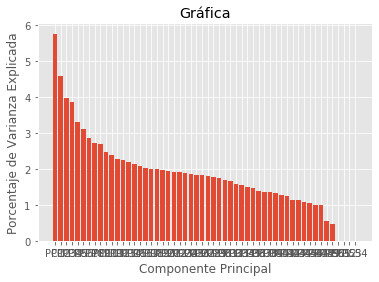

PAQUETE_TURISTICO_SI                     0.423050
GASTO                                    0.336083
ALOJ_CATEG_PROPIA                        0.328916
PAQUETE_TURISTICO_ALGUNO_GRATIS          0.325231
NACIONALIDAD_ESP724                      0.254414
ALOJ_CATEG_HOTEL4                        0.246099
ACTIV_PISCINA                            0.218182
PAQUETE_TURISTICO_PAGADO_POR_SEPARADO    0.196053
ACTIV_GASTRONOMIA_CANARIA                0.177939
ACTIV_ISLA                               0.164577
INGRESOS                                 0.154701
ALOJ_CATEG_PARTICULAR                    0.152117
NACIONALIDAD_GBR826                      0.150973
EDAD                                     0.149288
PERSONAS_TOTAL                           0.148694
ACTIV_NATURALEZA                         0.125550
ACTIV_EXCURS_ORGANIZ                     0.104461
PAQUETE_TURISTICO_NO_SABE                0.090171
ACTIV_POPULAR                            0.085181
NACIONALIDAD_ITA380                      0.077013


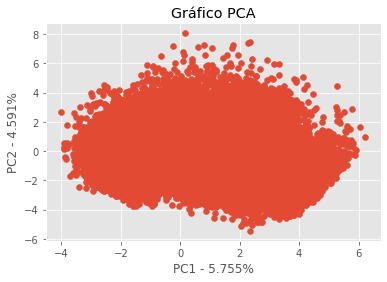

In [88]:
fs.show_pca(scaled_features)

### RECHAZADO
Usando estas variables parece que no identificamos clústeres distinguibles

## Primera aproximación - PCA con Nacionalidad y Gasto total

In [6]:
feature_list = ['NACIONALIDAD', 'GASTO']
features = X.loc[:, feature_list]
features = pd.get_dummies(features)
scaled_features = pd.DataFrame(scaler.fit_transform(features.values), columns=features.columns, index=features.index)
scaled_features = pd.get_dummies(scaled_features)

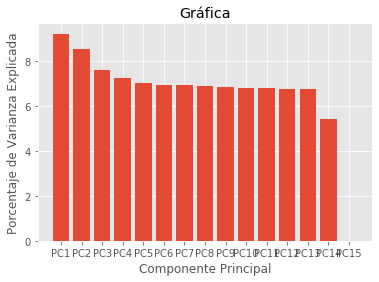

NACIONALIDAD_ESP724    0.669315
GASTO                  0.506236
NACIONALIDAD_GBR826    0.496450
NACIONALIDAD_DEU276    0.136617
NACIONALIDAD_ITA380    0.107582
NACIONALIDAD_ZZZ900    0.099427
NACIONALIDAD_FIN246    0.052881
NACIONALIDAD_DNK208    0.051608
NACIONALIDAD_SWE752    0.047806
NACIONALIDAD_NOR578    0.024622
NACIONALIDAD_IRL372    0.016634
NACIONALIDAD_CHE756    0.015068
NACIONALIDAD_FRA250    0.011524
NACIONALIDAD_NLD528    0.009258
NACIONALIDAD_BEL056    0.009078
dtype: float64
Index(['NACIONALIDAD_ESP724', 'GASTO', 'NACIONALIDAD_GBR826',
       'NACIONALIDAD_DEU276', 'NACIONALIDAD_ITA380', 'NACIONALIDAD_ZZZ900',
       'NACIONALIDAD_FIN246', 'NACIONALIDAD_DNK208', 'NACIONALIDAD_SWE752',
       'NACIONALIDAD_NOR578'],
      dtype='object')


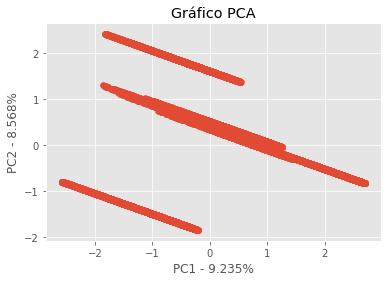

In [7]:
fs.show_pca(scaled_features)

Al usar la nacionalidad y el gasto total sí vemos 3 clústeres distinguibles con los que trabajar

In [4]:
X = dp.load_dataset('./datos/GASTO_TURISTICO_2018_ORIGINAL_2.csv', ';', ',', predictors=literatura, dummies=False,
                    desglose=True)

feature_list = ['NACIONALIDAD', 'GASTO', 'COSTE_ALOJ_EUROS', 'GASTO_EUROS', 'COSTE_VUELOS_EUROS', 'COSTE_PAQUETE_EUROS']

for col in X:
    if col.startswith('DESGLOSE_'):
        feature_list.append(col)

features = X.loc[:, feature_list]
features = pd.get_dummies(features)

print(features.shape)
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features.values), columns=features.columns, index=features.index)

c:\users\amct2\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(35767, 38)


C:\Users\amct2\PycharmProjects\tfg\data_preprocessing.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = x[(y > q1 - IQR)]


### Primera opción de segmentación (Gasto total + Nacionalidad ESP + Nacionalidad GBR)

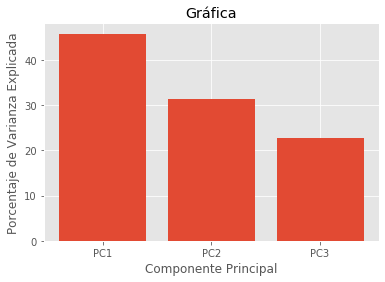

NACIONALIDAD_ESP724    0.675802
NACIONALIDAD_GBR826    0.575184
GASTO                  0.460929
dtype: float64
Index(['NACIONALIDAD_ESP724', 'NACIONALIDAD_GBR826', 'GASTO'], dtype='object')


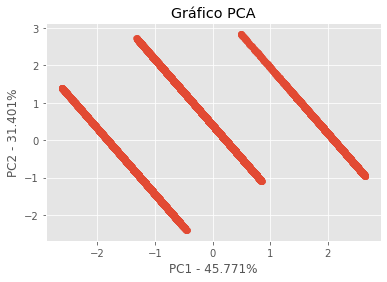

In [8]:
scaled_features = scaled_features.loc[:,['GASTO', 'NACIONALIDAD_ESP724', 'NACIONALIDAD_GBR826']]
fs.show_pca(scaled_features)
scaled_features = scaled_features.to_numpy()

## Posible combinacción de clúster  

Estas variables revelan 3 clústeres claramente diferenciados, vamos a ver si KMeans es capaz de identificarlos también

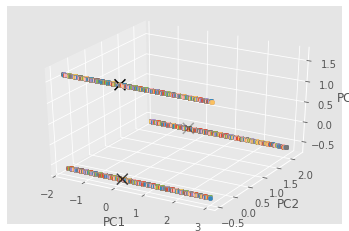

In [9]:
clf = KMeans(n_clusters=3)
clf.fit(scaled_features)
centroids = clf.cluster_centers_

# Array con las etiquetas de las características
labels = clf.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


colors = ['b.', 'r.', 'g']

for i in range(len(scaled_features)):
    ax.scatter(scaled_features[i][0], scaled_features[i][1], scaled_features[i][2], colors[labels[i]])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x', s=120, linewidths = 5, color='k')
plt.show(ax)

Parece que KMeans también ha identificado bien los 3 clústeres utilizando estas variables. Ahora vamos a analizar exactamente qué tiene cada uno de ellos.

In [10]:
# Para añadir las etiquetas del clúster al que pertenecen a las observaciones
clusters = X.copy()
clusters['CLUSTER'] = labels
clusters.head()

,PAIS_DESTINO,SEXO,EDAD,NACIONALIDAD,PAIS_RESIDENCIA,PROPOSITO,MOTIVACION_1,ANTELACION_VIAJE,CANAL_VISITAS_ANTERIORES,CANAL_AMIGOS_FAMILIARES,...,CALIFICAR_EXPERIENCIA,VOLVER_A_CANARIAS,RECOMENDAR_CANARIAS,NIVEL_EDUCATIVO,SITUACION_LABORAL,INGRESOS,PERSONAS_HOGAR,TRIMESTRE,GASTO,CLUSTER
0,ESP724,1,43,ESP724,ESP724,VACACIONES_OCIO_ENTRETENIMIENTO,DESCANSAR,1-2_MESES,1,1,...,3,8,9,ESTUDIOS_SUPERIORES,ASALARIADO_NEG_FAMIL_O_PRACT_REM,12500,2,2018Q3,600.04,0
1,NLD528,0,41,NLD528,NLD528,VACACIONES_OCIO_ENTRETENIMIENTO,DESCANSAR,MAS_DE_6_MESES,1,1,...,3,8,8,ESTUDIOS_SUPERIORES,ASALARIADO_NEG_FAMIL_O_PRACT_REM,37000,3,2018Q4,2010.00,1
2,DEU276,1,70,DEU276,DEU276,VACACIONES_OCIO_ENTRETENIMIENTO,DESCANSAR,1-2_MESES,1,0,...,3,9,9,ESTUDIOS_SUPERIORES,JUBILADO,12500,1,2018Q1,1394.00,1
3,GBR826,0,29,GBR826,GBR826,VACACIONES_OCIO_ENTRETENIMIENTO,DESCANSAR,1-15_DIAS,1,0,...,3,8,8,ESTUDIOS_SUPERIORES,ASALARIADO_NEG_FAMIL_O_PRACT_REM,37000,1,2018Q2,591.52,2
4,ESP724,0,38,ESP724,ESP724,VACACIONES_OCIO_ENTRETENIMIENTO,EXPLORAR_CONOCER_ISLAS,MAS_DE_6_MESES,0,1,...,4,10,10,ESTUDIOS_SUPERIORES,ASALARIADO_NEG_FAMIL_O_PRACT_REM,62000,2,2018Q3,1850.24,0


In [105]:
for cluster in clusters['CLUSTER'].unique():
    print("Clúster: ", cluster)
    print(clusters[clusters['CLUSTER'] == cluster].describe)

Clúster:  1
<bound method NDFrame.describe of       PAIS_DESTINO  SEXO  EDAD NACIONALIDAD PAIS_RESIDENCIA  \
0           ESP724     1    43       ESP724          ESP724   
4           ESP724     0    38       ESP724          ESP724   
6           DEU276     1    34       ESP724          DEU276   
8           ESP724     0    39       ESP724          FIN246   
12          ESP724     0    42       ESP724          ESP724   
...            ...   ...   ...          ...             ...   
37620       DEU276     0    38       ESP724          DEU276   
37692       ESP724     0    22       ESP724          ESP724   
37694       ESP724     1    32       ESP724          ESP724   
37696       ESP724     0    21       ESP724          ESP724   
37698       ESP724     1    43       ESP724          ESP724   

                             PROPOSITO            MOTIVACION_1  \
0      VACACIONES_OCIO_ENTRETENIMIENTO               DESCANSAR   
4      VACACIONES_OCIO_ENTRETENIMIENTO  EXPLORAR_CONOCER_ISLAS   

In [11]:
cluster_features = ['INGRESOS', 'GASTO', 'EDAD', 'GASTO_EUROS']
cluster_features_treat = ['EDAD', 'GASTO_EUROS']
categorical_features = ['SITUACION_LABORAL', 'ALOJ_CATEG', 'GRATIS_ALOJ']

desglose = []
importancia = []
for col in X:
    if col.startswith('DESGLOSE_'):
        desglose.append(col)
    if col.startswith('IMPORTANCIA_'):
        importancia.append(col)

## Clúster 0 - Resto de nacionalidades

In [133]:
cluster_0 = clusters[clusters['CLUSTER'] == 0]
cluster_0 = remove_outliers_cluster(cluster_0, cluster_features_treat)
cluster_0[cluster_features].describe()

c:\users\amct2\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,INGRESOS,GASTO,EDAD,GASTO_EUROS
count,19156.000000,19156.000000,19156.000000,19156.000000
mean,47432.031739,2225.651186,44.871372,565.010695
std,21466.189967,1175.544746,15.142054,345.466537
min,12500.000000,7.140000,16.000000,0.000000
25%,37000.000000,1369.872575,32.000000,300.000000
50%,37000.000000,2077.821900,45.000000,500.010000
75%,62000.000000,2934.133225,57.000000,779.345350
max,75000.000000,5847.240000,90.000000,1590.000000


In [134]:
(cluster_0['NACIONALIDAD'].value_counts()/cluster_0.shape[0])*100

DEU276    31.300898
ZZZ900    16.981625
NLD528     7.851326
FRA250     7.538108
ITA380     7.313635
SWE752     6.238254
IRL372     5.940697
BEL056     4.682606
NOR578     3.930883
DNK208     3.163500
FIN246     2.813740
CHE756     2.244728
Name: NACIONALIDAD, dtype: float64

Como podemos ver, el gasto medio del resto de nacionalidades se situa en los 2.300€ de los cuales 631€ corresponden al gasto en destino, suelen ser turistas que rondan los 45 años y con unos ingresos medios anuales de 47.618€

### Análisis de alojamiento, empleo y alojamiento gratis

In [135]:
for categ in categorical_features:
    print((cluster_0[categ].value_counts()/cluster_0.shape[0])*100)

ASALARIADO_NEG_FAMIL_O_PRACT_REM      55.799749
JUBILADO                              13.520568
AUTONOMO                              10.832115
ESTUDIANTE_PRACT_NO_REM                5.898935
EMP_MAS_10_EMPLEADOS                   5.825851
EMP_MENOS_10_EMPLEADOS                 5.460430
DESEMPLEADO                            1.064940
LABORES_HOGAR_CUIDADO_DEPENDIENTES     0.751723
OTROS                                  0.422844
INCAPACITADO_PERMANENTE                0.354980
SERV_MILITAR_O_COM_OBIGATORIO          0.067864
Name: SITUACION_LABORAL, dtype: float64
HOTEL4         36.228858
APART_VILLA    24.551054
HOTEL123       13.734600
OTROS           8.916266
PARTICULAR      6.039883
PROPIA          5.846732
HOTEL5          4.682606
Name: ALOJ_CATEG, dtype: float64
0    91.600543
1     8.399457
Name: GRATIS_ALOJ, dtype: float64


A nivel cualitativo vemos cómo el alojamiento preferido por el resto de nacionalidades tiende a ser el hotel de 4 estrellas seguido por los apartamentos y villas.  

En cuanto a la ocupación, vemos que el 55%  son asalariados en negocios familiares o estudiantes de prácticas remuneradas.

Por último, el 91% ha tenido que pagar por su alojamiento.

### Análisis de la composición del gasto en destino

In [142]:
cluster_0 = clusters[clusters['CLUSTER'] == 0]
#cluster_0 = remove_outliers_cluster(cluster_0, desglose)
cluster_0[desglose].describe()

,DESGLOSE_EXTRA_ALOJ,DESGLOSE_PASAJES_ISLAS,DESGLOSE_TAXI,DESGLOSE_ALQ_VEHIC,DESGLOSE_TRANSP_PUBLICO,DESGLOSE_ALIM_SUPER,DESGLOSE_RESTAURANT,DESGLOSE_EXCURS_ORGANIZ,DESGLOSE_DEPORTES,DESGLOSE_ACTIV_CULTURAL,DESGLOSE_MUSEOS,DESGLOSE_PARQUES_OCIO,DESGLOSE_DISCOTECAS,DESGLOSE_SALUD,DESGLOSE_SOUVENIRS,DESGLOSE_BIENES_INMUEBLES,DESGLOSE_OTRAS_COMPRAS,DESGLOSE_FARMACIA,DESGLOSE_OTROS_GASTOS
count,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000
mean,19.561434,5.815135,74.131499,57.822447,4.265101,103.787598,184.525215,40.706063,10.832465,2.310508,3.643472,9.437314,10.132230,4.420563,81.680992,0.926131,2.364665,4.870619,10.276363
std,115.161693,40.320610,98.585850,117.213801,26.619008,183.687224,260.979661,103.454779,58.909110,21.376906,21.327641,45.093901,57.843202,30.598689,168.670897,31.005182,44.373007,35.684006,69.096180
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,9.000833,0.000000,0.000000,39.989091,97.377778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,147.490094,80.080000,0.000000,142.382320,299.964000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000
max,3142.153846,1970.080000,2347.677675,2280.180000,1002.000000,3000.060000,4000.080000,1939.711475,1649.853333,1011.255000,750.014019,1300.126829,2099.964527,1023.472800,5199.940684,3000.000000,2999.790393,1292.740047,2999.920000


Especial atención merecen los desgloses en alimentación de supermercado (103 euros de media), en restaurantes (184€ de media), y souvenirs (81€ de media) 

### Análisis de la composición del gasto en destino

In [157]:
cluster_0 = clusters[clusters['CLUSTER'] == 0]
cluster_0[desglose].describe()

,DESGLOSE_EXTRA_ALOJ,DESGLOSE_PASAJES_ISLAS,DESGLOSE_TAXI,DESGLOSE_ALQ_VEHIC,DESGLOSE_TRANSP_PUBLICO,DESGLOSE_ALIM_SUPER,DESGLOSE_RESTAURANT,DESGLOSE_EXCURS_ORGANIZ,DESGLOSE_DEPORTES,DESGLOSE_ACTIV_CULTURAL,DESGLOSE_MUSEOS,DESGLOSE_PARQUES_OCIO,DESGLOSE_DISCOTECAS,DESGLOSE_SALUD,DESGLOSE_SOUVENIRS,DESGLOSE_BIENES_INMUEBLES,DESGLOSE_OTRAS_COMPRAS,DESGLOSE_FARMACIA,DESGLOSE_OTROS_GASTOS
count,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000,20017.000000
mean,19.561434,5.815135,74.131499,57.822447,4.265101,103.787598,184.525215,40.706063,10.832465,2.310508,3.643472,9.437314,10.132230,4.420563,81.680992,0.926131,2.364665,4.870619,10.276363
std,115.161693,40.320610,98.585850,117.213801,26.619008,183.687224,260.979661,103.454779,58.909110,21.376906,21.327641,45.093901,57.843202,30.598689,168.670897,31.005182,44.373007,35.684006,69.096180
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,9.000833,0.000000,0.000000,39.989091,97.377778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,147.490094,80.080000,0.000000,142.382320,299.964000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000
max,3142.153846,1970.080000,2347.677675,2280.180000,1002.000000,3000.060000,4000.080000,1939.711475,1649.853333,1011.255000,750.014019,1300.126829,2099.964527,1023.472800,5199.940684,3000.000000,2999.790393,1292.740047,2999.920000


Taxi (74€)  -> Puede valorar el recorrer la isla   
Alquiler vehículos (57€)  
Supermercado (103€)  
Restaurante (184€)  -> Puede valorar la gastronomía  
Souvenirs (81€)

In [158]:
(cluster_0['ACTIV_GASTRONOMIA_CANARIA'].value_counts()/cluster_0.shape[0])*100

0    74.761453
1    25.238547
Name: ACTIV_GASTRONOMIA_CANARIA, dtype: float64

In [159]:
(cluster_0['ACTIV_ISLA'].value_counts()/cluster_0.shape[0])*100

1    52.695209
0    47.304791
Name: ACTIV_ISLA, dtype: float64

In [160]:
(cluster_0['PAQUETE_TURISTICO'].value_counts()/cluster_0.shape[0])*100

SI                     59.014837
PAGADO_POR_SEPARADO    28.445821
ALGUNO_GRATIS           9.022331
NO_SABE                 3.517011
Name: PAQUETE_TURISTICO, dtype: float64

## Clúster 1 - Españoles

In [136]:
cluster_1 = clusters[clusters['CLUSTER'] == 1]
cluster_1 = remove_outliers_cluster(cluster_1, cluster_features_treat)
cluster_1[cluster_features].describe()

c:\users\amct2\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,INGRESOS,GASTO,EDAD,GASTO_EUROS
count,5862.000000,5862.000000,5862.000000,5862.000000
mean,37740.617537,1552.793556,40.236267,481.484042
std,20387.729276,1076.353384,12.087322,310.705686
min,12500.000000,6.000000,16.000000,0.000000
25%,12500.000000,690.000000,31.000000,230.020000
50%,37000.000000,1375.012100,40.000000,420.000000
75%,62000.000000,2199.840000,48.000000,679.972500
max,75000.000000,5785.082200,73.000000,1414.111800


En el caso de los tursitas españoles, vemos cómo la edad media ronda los 40 años, el gasto medio es de 1.640€ y cuentan con unos ingresos anuales de 38.088€ Respecto al gasto medio en destino, vemos cómo este es superior

### Análisis de alojamiento, empleo y alojamiento gratis

In [137]:
for categ in categorical_features:
    print((cluster_1[categ].value_counts()/cluster_1.shape[0])*100)

ASALARIADO_NEG_FAMIL_O_PRACT_REM      63.920164
AUTONOMO                              11.361310
ESTUDIANTE_PRACT_NO_REM                5.765950
JUBILADO                               5.697714
EMP_MENOS_10_EMPLEADOS                 4.418287
EMP_MAS_10_EMPLEADOS                   4.179461
DESEMPLEADO                            3.480041
LABORES_HOGAR_CUIDADO_DEPENDIENTES     0.665302
INCAPACITADO_PERMANENTE                0.255885
OTROS                                  0.238826
SERV_MILITAR_O_COM_OBIGATORIO          0.017059
Name: SITUACION_LABORAL, dtype: float64
HOTEL4         33.179802
PROPIA         19.361992
APART_VILLA    16.018424
HOTEL123       11.668373
PARTICULAR      7.147731
HOTEL5          6.960082
OTROS           5.663596
Name: ALOJ_CATEG, dtype: float64
0    79.0174
1    20.9826
Name: GRATIS_ALOJ, dtype: float64


Al igual que en el clúster 0, la situación laboral predominante son los asalariados en negocio familiar o estudiantes en prácticas remuneradas. 

Respecto al tipo de alojamiento, vemos cómo el Hotel de 4 estrellas sigue siendo la categoria predominante, pero también debemos destacar cómo casi un 20% se queda en una vivienda propia.

Finalmente, un aspecto que llama mucho la atención es cómo el 21% de los españoles cuenta con alojamiento gratis.  
Vamos a buscar una posible explicación a esto:

In [138]:
(pd.crosstab(cluster_1['ALOJ_CATEG'], cluster_1['PROPOSITO'])/cluster_1.shape[0])*100

PROPOSITO,EDUCACION_FORMACION,ENTRENAMIENTO_DEPORTIVO,FERIAS_CONGRESOS,NEGOCIOS_TRABAJO,OTRO,SALUD_ATENCION_MEDICA,VACACIONES_OCIO_ENTRETENIMIENTO,VISITA_FAMILIA_AMIGOS
ALOJ_CATEG,,,,,,,,
APART_VILLA,0.017059,0.085295,0.000000,0.614125,0.153531,0.017059,14.090754,1.040600
HOTEL123,0.051177,0.102354,0.068236,1.825316,0.068236,0.000000,8.955988,0.597066
HOTEL4,0.068236,0.136472,0.085295,3.172979,0.238826,0.000000,28.676220,0.801774
HOTEL5,0.000000,0.017059,0.051177,0.580007,0.034118,0.000000,6.038895,0.238826
OTROS,0.000000,0.153531,0.017059,0.307062,0.085295,0.000000,4.674173,0.426476
PARTICULAR,0.034118,0.051177,0.000000,0.511771,0.085295,0.017059,5.595360,0.852951
PROPIA,0.068236,0.034118,0.000000,0.443535,0.102354,0.017059,4.145343,14.551348


Como vemos en esta tabla cruzada un 14% de los integrantes del clúster se quedan en categoría propia con propósito de visita a familiares y amigos. 

### Análisis de la composición del gasto en destino

In [143]:
cluster_1 = clusters[clusters['CLUSTER'] == 1]
cluster_1[desglose].describe()

,DESGLOSE_EXTRA_ALOJ,DESGLOSE_PASAJES_ISLAS,DESGLOSE_TAXI,DESGLOSE_ALQ_VEHIC,DESGLOSE_TRANSP_PUBLICO,DESGLOSE_ALIM_SUPER,DESGLOSE_RESTAURANT,DESGLOSE_EXCURS_ORGANIZ,DESGLOSE_DEPORTES,DESGLOSE_ACTIV_CULTURAL,DESGLOSE_MUSEOS,DESGLOSE_PARQUES_OCIO,DESGLOSE_DISCOTECAS,DESGLOSE_SALUD,DESGLOSE_SOUVENIRS,DESGLOSE_BIENES_INMUEBLES,DESGLOSE_OTRAS_COMPRAS,DESGLOSE_FARMACIA,DESGLOSE_OTROS_GASTOS
count,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000,6152.000000
mean,19.704642,9.680226,22.782613,85.164536,4.318286,62.681067,168.502855,35.834833,7.480238,2.688144,5.176469,17.228126,8.192078,3.892779,76.528796,0.381177,1.815152,3.225174,8.143522
std,88.210660,45.289796,64.662479,116.668901,34.421491,122.972432,218.407736,87.616396,45.741619,19.897444,23.190237,60.760662,40.448967,35.735793,160.451687,10.510704,38.041617,28.225591,47.379527
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,20.000000,0.000000,12.000400,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.991333,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,150.000000,0.000000,80.016632,249.979336,15.545872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.995757,0.000000,0.000000,0.000000,0.000000
max,1540.044000,800.134266,2133.200000,1799.910000,2000.050794,2200.128000,4500.090000,1199.968000,1000.017230,400.026667,333.612000,1928.700000,1110.092500,2000.000000,3300.033418,500.000000,1900.000000,1125.000000,1000.020000


Alquiler de vehículos (85€)  -> Puede valorar el recorrer la isla  
Supermercado (62€)  
Restaurante (168€)  -> Puede valorar la gastronomía  
Souvenirs (76€)

In [145]:
(cluster_1['ACTIV_GASTRONOMIA_CANARIA'].value_counts()/cluster_1.shape[0])*100

0    57.688557
1    42.311443
Name: ACTIV_GASTRONOMIA_CANARIA, dtype: float64

In [146]:
(cluster_1['ACTIV_ISLA'].value_counts()/cluster_1.shape[0])*100

1    63.19896
0    36.80104
Name: ACTIV_ISLA, dtype: float64

In [152]:
(cluster_1['PAQUETE_TURISTICO'].value_counts()/cluster_1.shape[0])*100

PAGADO_POR_SEPARADO    44.505852
SI                     27.373212
ALGUNO_GRATIS          21.586476
NO_SABE                 6.534460
Name: PAQUETE_TURISTICO, dtype: float64

## Clúster 2 - Británicos

In [12]:
cluster_2 = clusters[clusters['CLUSTER'] == 2]
cluster_2 = remove_outliers_cluster(cluster_2, cluster_features_treat)
cluster_2[cluster_features].describe()

c:\users\amct2\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,INGRESOS,GASTO,EDAD,GASTO_EUROS
count,9140.000000,9140.000000,9140.000000,9140.000000
mean,47267.888403,2225.082561,46.606236,552.639101
std,21375.575646,1176.747917,15.213762,355.356262
min,12500.000000,20.000000,16.000000,0.000000
25%,37000.000000,1364.717325,35.000000,280.000000
50%,37000.000000,2039.830000,48.000000,499.940000
75%,62000.000000,2897.004500,58.000000,778.937700
max,75000.000000,5844.630300,89.000000,1624.245600


En el caso de los tursitas británicos, vemos cómo la edad media ronda los 46 años, el gasto medio es de 2.315€ y cuentan con unos ingresos anuales de 47.532€ Respecto al gasto medio en consumo, vemos cómo este ronda los 627€ de media

### Análisis de alojamiento, empleo y alojamiento gratis

In [140]:
for categ in categorical_features:
    print((cluster_2[categ].value_counts()/cluster_2.shape[0])*100)

ASALARIADO_NEG_FAMIL_O_PRACT_REM      60.787746
JUBILADO                              17.483589
AUTONOMO                              11.739606
ESTUDIANTE_PRACT_NO_REM                3.052516
EMP_MENOS_10_EMPLEADOS                 2.450766
EMP_MAS_10_EMPLEADOS                   1.750547
LABORES_HOGAR_CUIDADO_DEPENDIENTES     1.367615
DESEMPLEADO                            0.678337
INCAPACITADO_PERMANENTE                0.415755
OTROS                                  0.196937
SERV_MILITAR_O_COM_OBIGATORIO          0.076586
Name: SITUACION_LABORAL, dtype: float64
HOTEL4         38.107221
APART_VILLA    30.492341
HOTEL123       11.148796
HOTEL5          7.636761
OTROS           6.039387
PROPIA          3.698031
PARTICULAR      2.877462
Name: ALOJ_CATEG, dtype: float64
0    91.466083
1     8.533917
Name: GRATIS_ALOJ, dtype: float64


Al igual que en los cústeres 0 y 1, la situación laboral predominante son los asalariados en negocio familiar o estudiantes en prácticas remuneradas. 

Respecto al tipo de alojamiento, vemos cómo el Hotel de 4 estrellas sigue siendo la categoria predominante, pero también debemos destacar cómo un 32% se queda en una vivienda propia.

Finalmente, un aspecto que llama mucho la atención es cómo el 21% de los españoles cuenta con alojamiento gratis.  
Vamos a buscar una posible explicación a esto:

### Análisis de la composición del gasto en destino

In [13]:
cluster_2 = clusters[clusters['CLUSTER'] == 2]
cluster_2[desglose].describe()

,DESGLOSE_EXTRA_ALOJ,DESGLOSE_PASAJES_ISLAS,DESGLOSE_TAXI,DESGLOSE_ALQ_VEHIC,DESGLOSE_TRANSP_PUBLICO,DESGLOSE_ALIM_SUPER,DESGLOSE_RESTAURANT,DESGLOSE_EXCURS_ORGANIZ,DESGLOSE_DEPORTES,DESGLOSE_ACTIV_CULTURAL,DESGLOSE_MUSEOS,DESGLOSE_PARQUES_OCIO,DESGLOSE_DISCOTECAS,DESGLOSE_SALUD,DESGLOSE_SOUVENIRS,DESGLOSE_BIENES_INMUEBLES,DESGLOSE_OTRAS_COMPRAS,DESGLOSE_FARMACIA,DESGLOSE_OTROS_GASTOS
count,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000,9598.000000
mean,17.970857,3.833863,65.414577,20.589735,3.123089,103.530269,225.098006,26.615973,10.186657,2.504173,1.946012,12.428804,25.211913,4.144309,86.040485,0.383076,1.393885,4.437980,12.833048
std,113.014121,31.827337,72.324645,69.927610,24.701012,182.630661,300.003895,90.618638,57.403936,27.582791,17.697988,54.191532,91.784069,27.057167,177.389631,12.385519,26.521343,39.137242,104.834795
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,59.997000,0.000000,0.000000,30.002730,113.260000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,110.241300,0.000000,0.000000,134.728861,342.508500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.012000,0.000000,0.000000,0.000000,0.000000
max,2704.207350,1141.428571,1699.942616,1599.920000,1018.500000,3338.160000,4000.040000,2253.440000,1359.062069,1719.457895,649.842162,1283.604000,1708.480000,561.960000,5000.100000,750.000000,1131.657915,1500.000000,4000.080000


Taxi (65€)  -> Puede valorar el recorrer la isla o simplemente es para el aeropuerto  
Supermercado (103€)  
Restaurante (225€)  -> Puede valorar la gastronomía  
Souvenirs (86€)

In [154]:
(cluster_2['ACTIV_GASTRONOMIA_CANARIA'].value_counts()/cluster_2.shape[0])*100

0    78.537195
1    21.462805
Name: ACTIV_GASTRONOMIA_CANARIA, dtype: float64

In [155]:
(cluster_2['ACTIV_ISLA'].value_counts()/cluster_2.shape[0])*100

0    65.263597
1    34.736403
Name: ACTIV_ISLA, dtype: float64

In [156]:
(cluster_2['PAQUETE_TURISTICO'].value_counts()/cluster_2.shape[0])*100

SI                     58.480934
PAGADO_POR_SEPARADO    29.516566
ALGUNO_GRATIS           9.064388
NO_SABE                 2.938112
Name: PAQUETE_TURISTICO, dtype: float64